# Minimum num boundary sites - brick solutions

Created 15/09/2025

Objectives:
* For the fermionic models, find the smallest number of sites required for the boundary operators to succesfully read out the SPT phase.
Based off [this notebook](non_trivial_models_boundary_operators.ipynb).

# Package imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [4]:
from tqdm import tqdm

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    get_right_identity_environment_from_tp_tensor,
    multiply_stacked_unitaries_against_mps,
    inner_product_b_tensors,
    get_npc_identity_operator
)

from SPTOptimization.Optimizers.MPSBrickSolver import(
    MPSBrickSolver
)

# Load data

In [6]:
DATA_DIR_1 = r"../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [7]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [8]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

In [9]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

# Definitons

In [10]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [11]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [12]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [13]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [14]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [15]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [16]:
fermionic_np_symmetries = [np_I, np_JW]

In [17]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [18]:
npc_JW = fermionic_npc_symmetries[1]

In [19]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [20]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [21]:
cases_triv_proj_rep = dict()

for k, psi in loaded_data_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_triv_proj_rep[(k, i, j)] = case

In [22]:
for c in cases_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [23]:
cases_non_triv_proj_rep = dict()

for k, psi in loaded_data_non_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_non_triv_proj_rep[(k, i, j)] = case

In [24]:
for c in cases_non_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [25]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [26]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

## SPT functions

In [27]:
def calculate_proj_rep_phase(state_g, left_schmidt_values_g, unitary_h,
                             state_gh,
                             left_environment,
                             max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    prod_state, _ = multiply_stacked_unitaries_against_mps(
        unitary_h,
        state_g,
        left_schmidt_values_g,
        max_virtual_bond_dim
    )

    exp = inner_product_b_tensors(prod_state, state_gh, left_environment)

    return exp/(np.abs(exp))

In [28]:
def get_proj_rep_phases(mps_tensors, left_schmidt_values, unitaries,
                        left_environment):
    mps_dict = {
        k: v for k, v in zip(symmetry_labels[1:], mps_tensors)
    }

    schmidt_vals_dict = {
        k: v for k, v in zip(symmetry_labels[1:], left_schmidt_values)
    }

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()

    for a, b, c in group_products:
        phase = calculate_proj_rep_phase(
            mps_dict[a],
            schmidt_vals_dict[a],
            unitaries_dict[b],
            mps_dict[c],
            left_environment,
            max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
        )

        out_phases.append(phase)

    return out_phases

In [29]:
def get_right_proj_rep_phases_from_optimizers(optimizers):
    mps_tensors = [
        o.top_right_mps_tensors
        for o in optimizers[1:]
    ]

    left_schmidt_values = [
        o.current_right_side_left_schmidt_values
        for o in optimizers[1:]
    ]

    unitaries = [
        o.right_unitaries for o in optimizers[1:]
    ]

    left_environment = optimizers[0].right_side_left_symmetry_environment

    out = get_proj_rep_phases(
        mps_tensors,
        left_schmidt_values,
        unitaries,
        left_environment
    )

    return out

In [30]:
def get_left_proj_rep_phases_from_optimizers(optimizers):
    mps_tensors = [
        o.top_left_mps_tensors
        for o in optimizers[1:]
    ]

    left_schmidt_values = [
        o.current_left_side_right_schmidt_values
        for o in optimizers[1:]
    ]

    unitaries = [
        o.left_unitaries for o in optimizers[1:]
    ]

    left_environment = optimizers[0].left_side_right_symmetry_environment

    out = get_proj_rep_phases(
        mps_tensors,
        left_schmidt_values,
        unitaries,
        left_environment
    )

    return out

## Group data definitions

In [31]:
from itertools import combinations

In [32]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [33]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [34]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [35]:
e, a, b, c = symmetry_labels

In [36]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

In [37]:
symmetry_pair_labels = [
    a + ',' + b,
    a + ',' + c,
    c + ',' + b
]

# Calculate boundary operators

In [40]:
sub_cases_triv_proj_rep = {
    k: v for k, v in cases_triv_proj_rep.items()
    if (k[0] in [0.45, 0.55])
}

sub_cases_non_triv_proj_rep = {
    k: v for k, v in cases_non_triv_proj_rep.items()
    if (k[0] in [0.45, 0.55])
}

In [63]:
block_width = 3
num_one_sided_iterations = 3
num_two_sided_iterations = 3
num_layers = 4
num_sites_array = list(range(1, 7))
max_virtual_bond_dim = 30

In [64]:
optimizer_dict_triv_proj_rep = dict()

for num_sites in num_sites_array:
    for k, v in sub_cases_triv_proj_rep.items():
        opt = MPSBrickSolver(
            v,
            num_sites,
            block_width,
            num_layers,
            num_one_sided_iterations,
            num_two_sided_iterations,
            max_virtual_bond_dim=max_virtual_bond_dim
        )

        opt.optimise()
    
        optimizer_dict_triv_proj_rep[(num_sites, *k)] = opt

In [65]:
optimizer_dict_non_triv_proj_rep = dict()

for num_sites in num_sites_array:
    for k, v in sub_cases_non_triv_proj_rep.items():
        opt = MPSBrickSolver(
            v,
            num_sites,
            block_width,
            num_layers,
            num_one_sided_iterations,
            num_two_sided_iterations,
            max_virtual_bond_dim=max_virtual_bond_dim
        )

        opt.optimise()
    
        optimizer_dict_non_triv_proj_rep[(num_sites, *k)] = opt

## Expectations

In [66]:
final_exps_triv_proj_rep = dict()

for k, v in optimizer_dict_triv_proj_rep.items():
    final_exp = v.flatten_exps()[-1]
    final_exps_triv_proj_rep[k] = final_exp

In [70]:
final_exps_non_triv_proj_rep = dict()

for k, v in optimizer_dict_non_triv_proj_rep.items():
    final_exp = v.flatten_exps()[-1]
    final_exps_non_triv_proj_rep[k] = final_exp

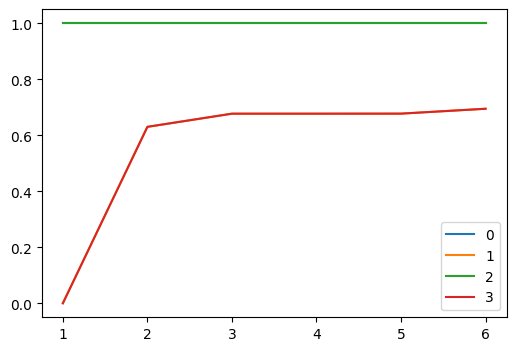

In [67]:
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(4):
    l = [final_exps_triv_proj_rep[(n, 0.45, 0, i)] for n in num_sites_array]
    ax.plot(num_sites_array, l, label=i)

ax.legend()

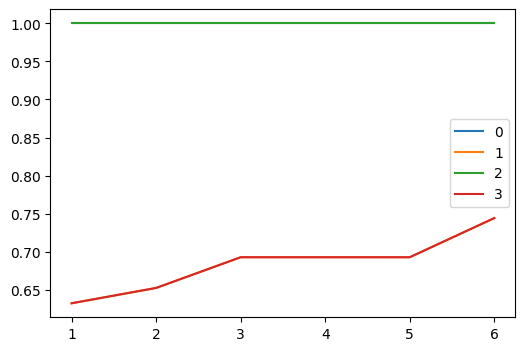

In [68]:
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(4):
    l = [final_exps_triv_proj_rep[(n, 0.55, 0, i)] for n in num_sites_array]
    ax.plot(num_sites_array, l, label=i)

ax.legend()

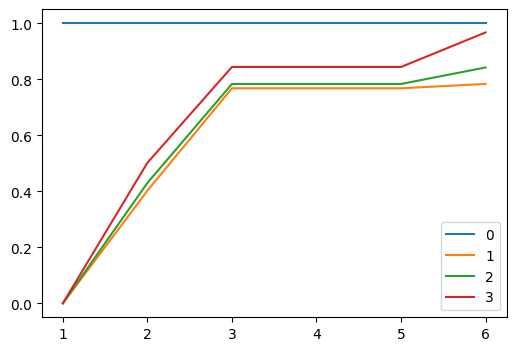

In [71]:
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(4):
    l = [final_exps_non_triv_proj_rep[(n, 0.45, 0, i)] for n in num_sites_array]
    ax.plot(num_sites_array, l, label=i)

ax.legend()

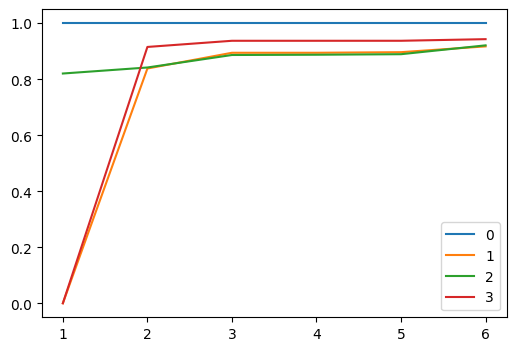

In [73]:
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(4):
    l = [final_exps_non_triv_proj_rep[(n, 0.55, 0, i)] for n in num_sites_array]
    ax.plot(num_sites_array, l, label=i)

ax.legend()

## 2 site boundary operators

Try with just two sites.

In [74]:
block_width = 2
num_one_sided_iterations = 3
num_two_sided_iterations = 3
num_layers = 1
num_sites = 2
max_virtual_bond_dim = 30

In [86]:
optimizer_dict_triv_proj_rep = dict()

for k, v in sub_cases_triv_proj_rep.items():
    opt = MPSBrickSolver(
        v,
        num_sites,
        block_width,
        num_layers,
        num_one_sided_iterations,
        num_two_sided_iterations,
        max_virtual_bond_dim=max_virtual_bond_dim
    )

    opt.optimise()

    optimizer_dict_triv_proj_rep[k] = opt

In [87]:
optimizer_dict_non_triv_proj_rep = dict()

for k, v in sub_cases_non_triv_proj_rep.items():
    opt = MPSBrickSolver(
        v,
        num_sites,
        block_width,
        num_layers,
        num_one_sided_iterations,
        num_two_sided_iterations,
        max_virtual_bond_dim=max_virtual_bond_dim
    )

    opt.optimise()

    optimizer_dict_non_triv_proj_rep[k] = opt

In [88]:
final_exps_triv_proj_rep = dict()

for k, v in optimizer_dict_triv_proj_rep.items():
    final_exp = v.flatten_exps()[-1]
    final_exps_triv_proj_rep[k] = final_exp

In [89]:
final_exps_non_triv_proj_rep = dict()

for k, v in optimizer_dict_non_triv_proj_rep.items():
    final_exp = v.flatten_exps()[-1]
    final_exps_non_triv_proj_rep[k] = final_exp

In [90]:
final_exps_triv_proj_rep

{(0.45, 0, 0): 1.0000000000000044,
 (0.45, 0, 1): 0.6301252448133341,
 (0.45, 0, 2): 1.000000000000005,
 (0.45, 0, 3): 0.6301252448133339,
 (0.45, 1, 0): 0.9200936211243678,
 (0.45, 1, 1): 0.0003693383392180253,
 (0.45, 1, 2): 0.9200936211243681,
 (0.45, 1, 3): 0.00036933833924156993,
 (0.55, 0, 0): 0.9999999999999989,
 (0.55, 0, 1): 0.6526209790918024,
 (0.55, 0, 2): 0.9999999999999984,
 (0.55, 0, 3): 0.6526209790918024,
 (0.55, 1, 0): 0.9319586119448048,
 (0.55, 1, 1): 0.6526209257988926,
 (0.55, 1, 2): 0.9319586119448043,
 (0.55, 1, 3): 0.6526209257988931}

In [91]:
final_exps_non_triv_proj_rep

{(0.45, 0, 0): 1.0000000000000075,
 (0.45, 0, 1): 0.40228303022128165,
 (0.45, 0, 2): 0.4299970080305304,
 (0.45, 0, 3): 0.5016710265072056,
 (0.45, 1, 0): 0.9095837712229543,
 (0.45, 1, 1): 0.38783058912207274,
 (0.45, 1, 2): 0.42137338739862906,
 (0.45, 1, 3): 0.5573607955708464,
 (0.55, 0, 0): 0.9999999999999973,
 (0.55, 0, 1): 0.838493454909399,
 (0.55, 0, 2): 0.8420927039614663,
 (0.55, 0, 3): 0.9154672312823906,
 (0.55, 1, 0): 0.9205726581087368,
 (0.55, 1, 1): 0.8132880312443168,
 (0.55, 1, 2): 0.8344147875246843,
 (0.55, 1, 3): 0.9125891352227052}

## Fermionic cohomology

In [92]:
def right_fp_charge(optimizer):
    opt = optimizer

    base_bs = opt.bottom_right_mps_tensors

    fp_bs = list()
    
    for i, b in enumerate(base_bs):
        # Need to update this logic
        if i%2:
            b_to_add = npc.tensordot(b, npc_JW, [['p',], ['p*',]])
        else:
            b_to_add = b
    
        fp_bs.append(b_to_add)

    fp_o_bs, _ = multiply_stacked_unitaries_against_mps(
        opt.right_unitaries,
        fp_bs,
        opt.original_right_side_left_schmidt_values,
        opt.max_virtual_bond_dim
    )

    out = inner_product_b_tensors(
        fp_o_bs,
        fp_bs,
        left_environment=opt.right_side_left_symmetry_environment
    )

    return out

In [93]:
right_fp_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_triv_proj_rep.items()):
    right_fp_triv_proj_rep_charges[k] = right_fp_charge(v)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 355.39it/s]


In [94]:
right_fp_non_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_non_triv_proj_rep.items()):
    right_fp_non_triv_proj_rep_charges[k] = right_fp_charge(v)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 320.16it/s]


In [96]:
interpolation_values = [0.45, 0.55]

In [97]:
right_fp_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [right_fp_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [right_fp_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    right_fp_triv_proj_rep_charges_list.append([l0, l1])

right_fp_triv_proj_rep_charges_array = np.array(right_fp_triv_proj_rep_charges_list)

In [102]:
right_fp_triv_proj_rep_charges_array

array([[[ 1.00000000e+00+0.j, -6.30125245e-01+0.j,  1.00000000e+00+0.j,
         -6.30125245e-01+0.j],
        [ 9.20093773e-01+0.j, -3.69338339e-04+0.j,  9.20093773e-01+0.j,
         -3.69338339e-04+0.j]],

       [[ 1.00000000e+00+0.j,  6.52621056e-01+0.j,  1.00000000e+00+0.j,
          6.52621056e-01+0.j],
        [ 9.31959125e-01+0.j,  6.52621002e-01+0.j,  9.31959125e-01+0.j,
          6.52621002e-01+0.j]]])

In [99]:
right_fp_non_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [right_fp_non_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [right_fp_non_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    right_fp_non_triv_proj_rep_charges_list.append([l0, l1])

right_fp_non_triv_proj_rep_charges_array = np.array(right_fp_non_triv_proj_rep_charges_list)

In [100]:
np.real(np.round(right_fp_non_triv_proj_rep_charges_array, 2))

array([[[ 1.  ,  0.4 , -0.43, -0.5 ],
        [ 0.91,  0.39, -0.42, -0.56]],

       [[ 1.  , -0.84,  0.84, -0.92],
        [ 0.92, -0.81,  0.83, -0.91]]])

## Extract phases

In [103]:
right_fp_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = right_fp_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        right_fp_triv_proj_rep_charges_dict[(t, j)] = sign_charge

In [104]:
right_fp_non_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = right_fp_non_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        right_fp_non_triv_proj_rep_charges_dict[(t, j)] = sign_charge

## Left side

In [105]:
def left_fp_charge(optimizer):
    opt = optimizer

    base_bs = opt.bottom_left_mps_tensors

    fp_bs = list()
    
    for i, b in enumerate(base_bs):
        # Need to update this logic
        if (i%2 == 0):
            b_to_add = npc.tensordot(b, npc_JW, [['p',], ['p*',]])
        else:
            b_to_add = b
    
        fp_bs.append(b_to_add)

    fp_o_bs, _ = multiply_stacked_unitaries_against_mps(
        opt.left_unitaries,
        fp_bs,
        opt.original_left_side_right_schmidt_values,
        opt.max_virtual_bond_dim
    )

    out = inner_product_b_tensors(
        fp_o_bs,
        fp_bs,
        left_environment=opt.left_side_right_symmetry_environment
    )

    return out

In [106]:
left_fp_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_triv_proj_rep.items()):
    left_fp_triv_proj_rep_charges[k] = left_fp_charge(v)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 228.56it/s]


In [107]:
left_fp_non_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_non_triv_proj_rep.items()):
    left_fp_non_triv_proj_rep_charges[k] = left_fp_charge(v)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 288.38it/s]


In [108]:
left_fp_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [left_fp_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [left_fp_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    left_fp_triv_proj_rep_charges_list.append([l0, l1])

left_fp_triv_proj_rep_charges_array = np.array(left_fp_triv_proj_rep_charges_list)

In [109]:
left_fp_non_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [left_fp_non_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [left_fp_non_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    left_fp_non_triv_proj_rep_charges_list.append([l0, l1])

left_fp_non_triv_proj_rep_charges_array = np.array(left_fp_non_triv_proj_rep_charges_list)

In [110]:
left_fp_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = left_fp_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        left_fp_triv_proj_rep_charges_dict[(t, j)] = sign_charge

In [111]:
left_fp_non_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = left_fp_non_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        left_fp_non_triv_proj_rep_charges_dict[(t, j)] = sign_charge

In [112]:
(
    left_fp_triv_proj_rep_charges_dict == right_fp_triv_proj_rep_charges_dict,
    left_fp_non_triv_proj_rep_charges_dict == right_fp_non_triv_proj_rep_charges_dict
)

(True, True)

Great, they agree so we only need one going forward.

Combine into single array.

In [113]:
fp_triv_proj_rep_charges_array = np.stack(
    [left_fp_triv_proj_rep_charges_array, right_fp_triv_proj_rep_charges_array],
    axis=-1
)

fp_non_triv_proj_rep_charges_array = np.stack(
    [left_fp_non_triv_proj_rep_charges_array, right_fp_non_triv_proj_rep_charges_array],
    axis=-1
)

fp_charges_array = np.stack(
    [fp_triv_proj_rep_charges_array, fp_non_triv_proj_rep_charges_array],
    axis=0
)

In [116]:
fp_charges_array.shape

(2, 2, 2, 4, 2)

In [117]:
np.max(np.abs(fp_charges_array[..., 0] - fp_charges_array[..., 1]))

4.379772788887237e-08

In [118]:
fp_charges_array = fp_charges_array[..., 0]

In [119]:
np.max(np.abs(fp_charges_array[..., 0, :] - fp_charges_array[..., 1, :]))

0.6297559509676743

In [120]:
np.max(np.abs(np.imag(fp_charges_array)))

1.6532535742558982e-05

In [121]:
fp_charges_array = np.real(fp_charges_array)

In [122]:
np.min(np.abs(fp_charges_array))

0.00036933764338752974

In [123]:
fp_charges_array.shape

(2, 2, 2, 4)

In [124]:
fp_charges_array

array([[[[ 1.00000000e+00, -6.30125289e-01,  1.00000000e+00,
          -6.30125289e-01],
         [ 9.20093779e-01, -3.69337643e-04,  9.20093779e-01,
          -3.69337643e-04]],

        [[ 1.00000000e+00,  6.52621062e-01,  1.00000000e+00,
           6.52621062e-01],
         [ 9.31959146e-01,  6.52621005e-01,  9.31959146e-01,
           6.52621005e-01]]],


       [[[ 1.00000000e+00,  4.02283030e-01, -4.29994107e-01,
          -5.01671027e-01],
         [ 9.09584109e-01,  3.87830589e-01, -4.21374080e-01,
          -5.57361203e-01]],

        [[ 1.00000000e+00, -8.38493455e-01,  8.42092704e-01,
          -9.15467231e-01],
         [ 9.20573352e-01, -8.13288031e-01,  8.34414788e-01,
          -9.12589011e-01]]]])

# Calculate proj reps

## Right side

In [125]:
right_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = right_fp_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_right_proj_rep_phases_from_optimizers(optimizers)

    right_triv_proj_rep_phases.append(phases)

right_triv_proj_rep_phases = np.array(right_triv_proj_rep_phases)

In [126]:
right_triv_proj_rep_phases.shape

(2, 6)

In [127]:
right_triv_proj_rep_phases

array([[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]])

In [128]:
right_triv_proj_rep_phases[:, ::2]/right_triv_proj_rep_phases[:, 1::2]

array([[1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j]])

In [129]:
right_non_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = right_fp_non_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_non_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_right_proj_rep_phases_from_optimizers(optimizers)

    right_non_triv_proj_rep_phases.append(phases)

right_non_triv_proj_rep_phases = np.array(right_non_triv_proj_rep_phases)

In [130]:
right_non_triv_proj_rep_phases.shape

(2, 6)

In [131]:
np.round(right_non_triv_proj_rep_phases, 2)

array([[0.56-0.83j, 0.41+0.91j, 0.56+0.83j, 0.42-0.91j, 0.56+0.83j,
        0.56-0.83j],
       [1.  -0.05j, 1.  +0.05j, 1.  +0.05j, 1.  -0.05j, 1.  +0.05j,
        1.  -0.05j]])

Why are these phases so clean...

In [132]:
np.round(
    right_non_triv_proj_rep_phases[:, ::2]/right_non_triv_proj_rep_phases[:, 1::2],
    2
)

array([[-0.52-0.85j, -0.52+0.85j, -0.36+0.93j],
       [ 0.99-0.1j ,  0.99+0.1j ,  0.99+0.1j ]])

## Left side

In [133]:
left_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = left_fp_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_left_proj_rep_phases_from_optimizers(optimizers)

    left_triv_proj_rep_phases.append(phases)

left_triv_proj_rep_phases = np.array(left_triv_proj_rep_phases)

In [134]:
left_triv_proj_rep_phases.shape

(2, 6)

In [135]:
left_triv_proj_rep_phases

array([[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]])

In [136]:
left_triv_proj_rep_phases[:, ::2]/left_triv_proj_rep_phases[:, 1::2]

array([[1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j]])

In [137]:
left_non_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = left_fp_non_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_non_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_left_proj_rep_phases_from_optimizers(optimizers)

    left_non_triv_proj_rep_phases.append(phases)

left_non_triv_proj_rep_phases = np.array(left_non_triv_proj_rep_phases)

In [138]:
left_non_triv_proj_rep_phases.shape

(2, 6)

In [139]:
np.round(left_non_triv_proj_rep_phases, 2)

array([[-0.56+0.83j, -0.41-0.91j, -0.57-0.82j, -0.41+0.91j, -0.56-0.83j,
        -0.56+0.83j],
       [ 1.  -0.05j,  1.  +0.05j,  1.  +0.05j,  1.  -0.05j,  1.  +0.05j,
         1.  -0.05j]])

In [140]:
np.round(
    left_non_triv_proj_rep_phases[:, ::2]/left_non_triv_proj_rep_phases[:, 1::2],
    2
)

array([[-0.52-0.85j, -0.52+0.85j, -0.36+0.93j],
       [ 0.99-0.1j ,  0.99+0.1j ,  0.99+0.1j ]])

# 4 site boundary operators

In [220]:
block_width = 4
num_one_sided_iterations = 3
num_two_sided_iterations = 3
num_layers = 1
num_sites = 4
max_virtual_bond_dim = 30

In [221]:
optimizer_dict_triv_proj_rep = dict()

for k, v in sub_cases_triv_proj_rep.items():
    opt = MPSBrickSolver(
        v,
        num_sites,
        block_width,
        num_layers,
        num_one_sided_iterations,
        num_two_sided_iterations,
        max_virtual_bond_dim=max_virtual_bond_dim
    )

    opt.optimise()

    optimizer_dict_triv_proj_rep[k] = opt

In [222]:
optimizer_dict_non_triv_proj_rep = dict()

for k, v in sub_cases_non_triv_proj_rep.items():
    opt = MPSBrickSolver(
        v,
        num_sites,
        block_width,
        num_layers,
        num_one_sided_iterations,
        num_two_sided_iterations,
        max_virtual_bond_dim=max_virtual_bond_dim
    )

    opt.optimise()

    optimizer_dict_non_triv_proj_rep[k] = opt

In [223]:
final_exps_triv_proj_rep = dict()

for k, v in optimizer_dict_triv_proj_rep.items():
    final_exp = v.flatten_exps()[-1]
    final_exps_triv_proj_rep[k] = final_exp

In [224]:
final_exps_non_triv_proj_rep = dict()

for k, v in optimizer_dict_non_triv_proj_rep.items():
    final_exp = v.flatten_exps()[-1]
    final_exps_non_triv_proj_rep[k] = final_exp

In [225]:
final_exps_triv_proj_rep

{(0.45, 0, 0): 1.0000000000000053,
 (0.45, 0, 1): 0.7409787485936199,
 (0.45, 0, 2): 1.0000000000000062,
 (0.45, 0, 3): 0.7409787485936201,
 (0.45, 1, 0): 0.9860698499078594,
 (0.45, 1, 1): 0.0006923286547485839,
 (0.45, 1, 2): 0.9860698499078601,
 (0.45, 1, 3): 0.0007113197349499938,
 (0.55, 0, 0): 1.0000000000000027,
 (0.55, 0, 1): 0.7505592909184029,
 (0.55, 0, 2): 1.0000000000000024,
 (0.55, 0, 3): 0.7505592909184031,
 (0.55, 1, 0): 0.9874118002201444,
 (0.55, 1, 1): 0.7505545224746991,
 (0.55, 1, 2): 0.9874118002201445,
 (0.55, 1, 3): 0.7505545224746994}

In [226]:
final_exps_non_triv_proj_rep

{(0.45, 0, 0): 1.0000000000000078,
 (0.45, 0, 1): 0.9210164523876798,
 (0.45, 0, 2): 0.9223184157785974,
 (0.45, 0, 3): 0.9836139264399386,
 (0.45, 1, 0): 0.9859244374124845,
 (0.45, 1, 1): 0.9222355627631857,
 (0.45, 1, 2): 0.921104528953456,
 (0.45, 1, 3): 0.9974724775088682,
 (0.55, 0, 0): 0.9999999999999973,
 (0.55, 0, 1): 0.9481672262828876,
 (0.55, 0, 2): 0.94170778189595,
 (0.55, 0, 3): 0.9829959023633228,
 (0.55, 1, 0): 0.9831962199993598,
 (0.55, 1, 1): 0.9417863726224306,
 (0.55, 1, 2): 0.9483714649964785,
 (0.55, 1, 3): 0.9991938656794085}

## Fermionic cohomology

In [227]:
def right_fp_charge(optimizer):
    opt = optimizer

    base_bs = opt.bottom_right_mps_tensors

    fp_bs = list()
    
    for i, b in enumerate(base_bs):
        # Need to update this logic
        if i%2:
            b_to_add = npc.tensordot(b, npc_JW, [['p',], ['p*',]])
        else:
            b_to_add = b
    
        fp_bs.append(b_to_add)

    fp_o_bs, _ = multiply_stacked_unitaries_against_mps(
        opt.right_unitaries,
        fp_bs,
        opt.original_right_side_left_schmidt_values,
        opt.max_virtual_bond_dim
    )

    out = inner_product_b_tensors(
        fp_o_bs,
        fp_bs,
        left_environment=opt.right_side_left_symmetry_environment
    )

    return out

In [228]:
right_fp_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_triv_proj_rep.items()):
    right_fp_triv_proj_rep_charges[k] = right_fp_charge(v)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.33it/s]


In [229]:
right_fp_non_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_non_triv_proj_rep.items()):
    right_fp_non_triv_proj_rep_charges[k] = right_fp_charge(v)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.84it/s]


In [230]:
interpolation_values = [0.45, 0.55]

In [231]:
right_fp_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [right_fp_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [right_fp_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    right_fp_triv_proj_rep_charges_list.append([l0, l1])

right_fp_triv_proj_rep_charges_array = np.array(right_fp_triv_proj_rep_charges_list)

In [232]:
right_fp_triv_proj_rep_charges_array

array([[[ 1.00000000e+00+0.j, -7.40979427e-01+0.j,  1.00000000e+00+0.j,
         -7.40979427e-01+0.j],
        [ 9.86071576e-01+0.j, -6.92329677e-04+0.j,  9.86071576e-01+0.j,
         -7.11317976e-04+0.j]],

       [[ 1.00000000e+00+0.j,  7.50560635e-01+0.j,  1.00000000e+00+0.j,
          7.50560635e-01+0.j],
        [ 9.87412978e-01+0.j,  7.50555425e-01+0.j,  9.87412978e-01+0.j,
          7.50555425e-01+0.j]]])

In [233]:
right_fp_non_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [right_fp_non_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [right_fp_non_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    right_fp_non_triv_proj_rep_charges_list.append([l0, l1])

right_fp_non_triv_proj_rep_charges_array = np.array(right_fp_non_triv_proj_rep_charges_list)

In [234]:
np.real(np.round(right_fp_non_triv_proj_rep_charges_array, 2))

array([[[ 1.  ,  0.92, -0.92, -0.98],
        [ 0.99,  0.92, -0.92, -1.  ]],

       [[ 1.  , -0.95,  0.94, -0.98],
        [ 0.98, -0.94,  0.95, -1.  ]]])

## Extract phases

In [235]:
right_fp_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = right_fp_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        right_fp_triv_proj_rep_charges_dict[(t, j)] = sign_charge

In [236]:
right_fp_non_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = right_fp_non_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        right_fp_non_triv_proj_rep_charges_dict[(t, j)] = sign_charge

## Left side

In [237]:
def left_fp_charge(optimizer):
    opt = optimizer

    base_bs = opt.bottom_left_mps_tensors

    fp_bs = list()
    
    for i, b in enumerate(base_bs):
        # Need to update this logic
        if (i%2 == 0):
            b_to_add = npc.tensordot(b, npc_JW, [['p',], ['p*',]])
        else:
            b_to_add = b
    
        fp_bs.append(b_to_add)

    fp_o_bs, _ = multiply_stacked_unitaries_against_mps(
        opt.left_unitaries,
        fp_bs,
        opt.original_left_side_right_schmidt_values,
        opt.max_virtual_bond_dim
    )

    out = inner_product_b_tensors(
        fp_o_bs,
        fp_bs,
        left_environment=opt.left_side_right_symmetry_environment
    )

    return out

In [238]:
left_fp_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_triv_proj_rep.items()):
    left_fp_triv_proj_rep_charges[k] = left_fp_charge(v)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.99it/s]


In [239]:
left_fp_non_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_non_triv_proj_rep.items()):
    left_fp_non_triv_proj_rep_charges[k] = left_fp_charge(v)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.37it/s]


In [240]:
left_fp_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [left_fp_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [left_fp_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    left_fp_triv_proj_rep_charges_list.append([l0, l1])

left_fp_triv_proj_rep_charges_array = np.array(left_fp_triv_proj_rep_charges_list)

In [241]:
left_fp_non_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [left_fp_non_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [left_fp_non_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    left_fp_non_triv_proj_rep_charges_list.append([l0, l1])

left_fp_non_triv_proj_rep_charges_array = np.array(left_fp_non_triv_proj_rep_charges_list)

In [242]:
left_fp_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = left_fp_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        left_fp_triv_proj_rep_charges_dict[(t, j)] = sign_charge

In [243]:
left_fp_non_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = left_fp_non_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        left_fp_non_triv_proj_rep_charges_dict[(t, j)] = sign_charge

In [244]:
(
    left_fp_triv_proj_rep_charges_dict == right_fp_triv_proj_rep_charges_dict,
    left_fp_non_triv_proj_rep_charges_dict == right_fp_non_triv_proj_rep_charges_dict
)

(True, True)

Great, they agree so we only need one going forward.

Combine into single array.

In [245]:
fp_triv_proj_rep_charges_array = np.stack(
    [left_fp_triv_proj_rep_charges_array, right_fp_triv_proj_rep_charges_array],
    axis=-1
)

fp_non_triv_proj_rep_charges_array = np.stack(
    [left_fp_non_triv_proj_rep_charges_array, right_fp_non_triv_proj_rep_charges_array],
    axis=-1
)

fp_charges_array = np.stack(
    [fp_triv_proj_rep_charges_array, fp_non_triv_proj_rep_charges_array],
    axis=0
)

In [246]:
fp_charges_array.shape

(2, 2, 2, 4, 2)

In [247]:
np.max(np.abs(fp_charges_array[..., 0] - fp_charges_array[..., 1]))

4.887445307240312e-06

In [248]:
fp_charges_array = fp_charges_array[..., 0]

In [249]:
np.max(np.abs(fp_charges_array[..., 0, :] - fp_charges_array[..., 1, :]))

0.7402872655293593

In [250]:
np.max(np.abs(np.imag(fp_charges_array)))

8.318972503619264e-06

In [251]:
fp_charges_array = np.real(fp_charges_array)

In [252]:
np.min(np.abs(fp_charges_array))

0.0006923218426385571

In [253]:
fp_charges_array.shape

(2, 2, 2, 4)

In [254]:
fp_charges_array

array([[[[ 1.00000000e+00, -7.40979587e-01,  1.00000000e+00,
          -7.40979587e-01],
         [ 9.86070857e-01, -6.92321843e-04,  9.86070857e-01,
          -7.11273566e-04]],

        [[ 1.00000000e+00,  7.50559685e-01,  1.00000000e+00,
           7.50559685e-01],
         [ 9.87412877e-01,  7.50554867e-01,  9.87412877e-01,
           7.50554867e-01]]],


       [[[ 1.00000000e+00,  9.21050385e-01, -9.22350824e-01,
          -9.83629346e-01],
         [ 9.85929128e-01,  9.22278918e-01, -9.21140960e-01,
          -9.97477546e-01]],

        [[ 1.00000000e+00, -9.48209658e-01,  9.41764266e-01,
          -9.83042410e-01],
         [ 9.83228503e-01, -9.41842676e-01,  9.48410994e-01,
          -9.99199270e-01]]]])

# Calculate proj reps

## Right side

In [255]:
right_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = right_fp_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_right_proj_rep_phases_from_optimizers(optimizers)

    right_triv_proj_rep_phases.append(phases)

right_triv_proj_rep_phases = np.array(right_triv_proj_rep_phases)

In [256]:
right_triv_proj_rep_phases.shape

(2, 6)

In [257]:
right_triv_proj_rep_phases

array([[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]])

In [258]:
right_triv_proj_rep_phases[:, ::2]/right_triv_proj_rep_phases[:, 1::2]

array([[1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j]])

In [259]:
right_non_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = right_fp_non_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_non_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_right_proj_rep_phases_from_optimizers(optimizers)

    right_non_triv_proj_rep_phases.append(phases)

right_non_triv_proj_rep_phases = np.array(right_non_triv_proj_rep_phases)

In [260]:
right_non_triv_proj_rep_phases.shape

(2, 6)

In [261]:
np.round(right_non_triv_proj_rep_phases, 2)

array([[-0.-1.j,  0.+1.j, -0.+1.j,  0.-1.j, -0.+1.j, -0.-1.j],
       [ 1.-0.j,  1.-0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j]])

Why are these phases so clean...

In [262]:
np.round(
    right_non_triv_proj_rep_phases[:, ::2]/right_non_triv_proj_rep_phases[:, 1::2],
    2
)

array([[-1.+0.j, -1.-0.j, -1.-0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j]])

## Left side

In [263]:
left_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = left_fp_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_left_proj_rep_phases_from_optimizers(optimizers)

    left_triv_proj_rep_phases.append(phases)

left_triv_proj_rep_phases = np.array(left_triv_proj_rep_phases)

In [264]:
left_triv_proj_rep_phases.shape

(2, 6)

In [265]:
left_triv_proj_rep_phases

array([[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]])

In [266]:
left_triv_proj_rep_phases[:, ::2]/left_triv_proj_rep_phases[:, 1::2]

array([[1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j]])

In [267]:
left_non_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = left_fp_non_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_non_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_left_proj_rep_phases_from_optimizers(optimizers)

    left_non_triv_proj_rep_phases.append(phases)

left_non_triv_proj_rep_phases = np.array(left_non_triv_proj_rep_phases)

In [268]:
left_non_triv_proj_rep_phases.shape

(2, 6)

In [269]:
np.round(left_non_triv_proj_rep_phases, 2)

array([[-0.+1.j,  0.-1.j, -0.-1.j,  0.+1.j,  0.-1.j,  0.+1.j],
       [ 1.+0.j,  1.+0.j,  1.-0.j,  1.-0.j,  1.-0.j,  1.-0.j]])

In [270]:
np.round(
    left_non_triv_proj_rep_phases[:, ::2]/left_non_triv_proj_rep_phases[:, 1::2],
    2
)

array([[-1.+0.j, -1.-0.j, -1.-0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j]])

# 6 site boundary operators

In [168]:
block_width = 6
num_one_sided_iterations = 3
num_two_sided_iterations = 3
num_layers = 3
num_sites = 4
max_virtual_bond_dim = 30

In [169]:
optimizer_dict_triv_proj_rep = dict()

for k, v in sub_cases_triv_proj_rep.items():
    opt = MPSBrickSolver(
        v,
        num_sites,
        block_width,
        num_layers,
        num_one_sided_iterations,
        num_two_sided_iterations,
        max_virtual_bond_dim=max_virtual_bond_dim
    )

    opt.optimise()

    optimizer_dict_triv_proj_rep[k] = opt

In [170]:
optimizer_dict_non_triv_proj_rep = dict()

for k, v in sub_cases_non_triv_proj_rep.items():
    opt = MPSBrickSolver(
        v,
        num_sites,
        block_width,
        num_layers,
        num_one_sided_iterations,
        num_two_sided_iterations,
        max_virtual_bond_dim=max_virtual_bond_dim
    )

    opt.optimise()

    optimizer_dict_non_triv_proj_rep[k] = opt

In [171]:
final_exps_triv_proj_rep = dict()

for k, v in optimizer_dict_triv_proj_rep.items():
    final_exp = v.flatten_exps()[-1]
    final_exps_triv_proj_rep[k] = final_exp

In [172]:
final_exps_non_triv_proj_rep = dict()

for k, v in optimizer_dict_non_triv_proj_rep.items():
    final_exp = v.flatten_exps()[-1]
    final_exps_non_triv_proj_rep[k] = final_exp

In [173]:
final_exps_triv_proj_rep

{(0.45, 0, 0): 1.0000000000000056,
 (0.45, 0, 1): 0.7409803043779463,
 (0.45, 0, 2): 1.0000000000000069,
 (0.45, 0, 3): 0.7409803043779463,
 (0.45, 1, 0): 0.9860733345298961,
 (0.45, 1, 1): 0.740974600267953,
 (0.45, 1, 2): 0.9860733345298968,
 (0.45, 1, 3): 0.7409765207325233,
 (0.55, 0, 0): 1.0000000000000027,
 (0.55, 0, 1): 0.7505609766222925,
 (0.55, 0, 2): 1.0000000000000038,
 (0.55, 0, 3): 0.7505609766222936,
 (0.55, 1, 0): 0.9874161420869685,
 (0.55, 1, 1): 0.7505559031467769,
 (0.55, 1, 2): 0.9874161420869693,
 (0.55, 1, 3): 0.7505559031467776}

In [174]:
final_exps_non_triv_proj_rep

{(0.45, 0, 0): 1.0000000000000075,
 (0.45, 0, 1): 0.9211680882585329,
 (0.45, 0, 2): 0.922484547144665,
 (0.45, 0, 3): 0.983673692780792,
 (0.45, 1, 0): 0.9859422136013858,
 (0.45, 1, 1): 0.9224246299978058,
 (0.45, 1, 2): 0.9212600414659521,
 (0.45, 1, 3): 0.997491547345575,
 (0.55, 0, 0): 0.9999999999999982,
 (0.55, 0, 1): 0.9483351090110759,
 (0.55, 0, 2): 0.9419091824869232,
 (0.55, 0, 3): 0.9831836903799889,
 (0.55, 1, 0): 0.9833273098924056,
 (0.55, 1, 1): 0.942000804860004,
 (0.55, 1, 2): 0.9485393506253499,
 (0.55, 1, 3): 0.999215501547628}

## Fermionic cohomology

In [175]:
def right_fp_charge(optimizer):
    opt = optimizer

    base_bs = opt.bottom_right_mps_tensors

    fp_bs = list()
    
    for i, b in enumerate(base_bs):
        # Need to update this logic
        if i%2:
            b_to_add = npc.tensordot(b, npc_JW, [['p',], ['p*',]])
        else:
            b_to_add = b
    
        fp_bs.append(b_to_add)

    fp_o_bs, _ = multiply_stacked_unitaries_against_mps(
        opt.right_unitaries,
        fp_bs,
        opt.original_right_side_left_schmidt_values,
        opt.max_virtual_bond_dim
    )

    out = inner_product_b_tensors(
        fp_o_bs,
        fp_bs,
        left_environment=opt.right_side_left_symmetry_environment
    )

    return out

In [176]:
right_fp_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_triv_proj_rep.items()):
    right_fp_triv_proj_rep_charges[k] = right_fp_charge(v)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.45it/s]


In [177]:
right_fp_non_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_non_triv_proj_rep.items()):
    right_fp_non_triv_proj_rep_charges[k] = right_fp_charge(v)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


In [178]:
interpolation_values = [0.45, 0.55]

In [179]:
right_fp_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [right_fp_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [right_fp_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    right_fp_triv_proj_rep_charges_list.append([l0, l1])

right_fp_triv_proj_rep_charges_array = np.array(right_fp_triv_proj_rep_charges_list)

In [180]:
right_fp_triv_proj_rep_charges_array

array([[[ 1.        +0.j, -0.7409803 +0.j,  1.        +0.j,
         -0.7409803 +0.j],
        [ 0.98607334+0.j, -0.7409746 +0.j,  0.98607334+0.j,
         -0.74097653+0.j]],

       [[ 1.        +0.j,  0.75056111+0.j,  1.        +0.j,
          0.75056111+0.j],
        [ 0.98741614+0.j,  0.75055604+0.j,  0.98741614+0.j,
          0.75055604+0.j]]])

In [181]:
right_fp_non_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [right_fp_non_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [right_fp_non_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    right_fp_non_triv_proj_rep_charges_list.append([l0, l1])

right_fp_non_triv_proj_rep_charges_array = np.array(right_fp_non_triv_proj_rep_charges_list)

In [182]:
np.real(np.round(right_fp_non_triv_proj_rep_charges_array, 2))

array([[[ 1.  ,  0.92, -0.92, -0.98],
        [ 0.99,  0.92, -0.92, -1.  ]],

       [[ 1.  , -0.95,  0.94, -0.98],
        [ 0.98, -0.94,  0.95, -1.  ]]])

## Extract phases

In [184]:
right_fp_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = right_fp_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        right_fp_triv_proj_rep_charges_dict[(t, j)] = sign_charge

In [185]:
right_fp_non_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = right_fp_non_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        right_fp_non_triv_proj_rep_charges_dict[(t, j)] = sign_charge

## Left side

In [186]:
def left_fp_charge(optimizer):
    opt = optimizer

    base_bs = opt.bottom_left_mps_tensors

    fp_bs = list()
    
    for i, b in enumerate(base_bs):
        # Need to update this logic
        if (i%2 == 0):
            b_to_add = npc.tensordot(b, npc_JW, [['p',], ['p*',]])
        else:
            b_to_add = b
    
        fp_bs.append(b_to_add)

    fp_o_bs, _ = multiply_stacked_unitaries_against_mps(
        opt.left_unitaries,
        fp_bs,
        opt.original_left_side_right_schmidt_values,
        opt.max_virtual_bond_dim
    )

    out = inner_product_b_tensors(
        fp_o_bs,
        fp_bs,
        left_environment=opt.left_side_right_symmetry_environment
    )

    return out

In [187]:
left_fp_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_triv_proj_rep.items()):
    left_fp_triv_proj_rep_charges[k] = left_fp_charge(v)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.55it/s]


In [188]:
left_fp_non_triv_proj_rep_charges = dict()

for k, v in tqdm(optimizer_dict_non_triv_proj_rep.items()):
    left_fp_non_triv_proj_rep_charges[k] = left_fp_charge(v)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


In [189]:
left_fp_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [left_fp_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [left_fp_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    left_fp_triv_proj_rep_charges_list.append([l0, l1])

left_fp_triv_proj_rep_charges_array = np.array(left_fp_triv_proj_rep_charges_list)

In [190]:
left_fp_non_triv_proj_rep_charges_list = list()

for t in interpolation_values:
    l0 = [left_fp_non_triv_proj_rep_charges[(t,0,i)] for i in range(4)]
    l1 = [left_fp_non_triv_proj_rep_charges[(t,1,i)] for i in range(4)]
    
    left_fp_non_triv_proj_rep_charges_list.append([l0, l1])

left_fp_non_triv_proj_rep_charges_array = np.array(left_fp_non_triv_proj_rep_charges_list)

In [191]:
left_fp_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = left_fp_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        left_fp_triv_proj_rep_charges_dict[(t, j)] = sign_charge

In [192]:
left_fp_non_triv_proj_rep_charges_dict = dict()

for i, t in enumerate(interpolation_values):
    for j in range(4):
        charge = left_fp_non_triv_proj_rep_charges_array[i, 0, j]
        sign_charge = 1 if charge > 0 else -1
    
        left_fp_non_triv_proj_rep_charges_dict[(t, j)] = sign_charge

In [193]:
(
    left_fp_triv_proj_rep_charges_dict == right_fp_triv_proj_rep_charges_dict,
    left_fp_non_triv_proj_rep_charges_dict == right_fp_non_triv_proj_rep_charges_dict
)

(True, True)

Great, they agree so we only need one going forward.

Combine into single array.

In [194]:
fp_triv_proj_rep_charges_array = np.stack(
    [left_fp_triv_proj_rep_charges_array, right_fp_triv_proj_rep_charges_array],
    axis=-1
)

fp_non_triv_proj_rep_charges_array = np.stack(
    [left_fp_non_triv_proj_rep_charges_array, right_fp_non_triv_proj_rep_charges_array],
    axis=-1
)

fp_charges_array = np.stack(
    [fp_triv_proj_rep_charges_array, fp_non_triv_proj_rep_charges_array],
    axis=0
)

In [195]:
fp_charges_array.shape

(2, 2, 2, 4, 2)

In [196]:
np.max(np.abs(fp_charges_array[..., 0] - fp_charges_array[..., 1]))

8.998403709008246e-07

In [197]:
fp_charges_array = fp_charges_array[..., 0]

In [198]:
np.max(np.abs(fp_charges_array[..., 0, :] - fp_charges_array[..., 1, :]))

0.016667516522387057

In [199]:
np.max(np.abs(np.imag(fp_charges_array)))

4.390268806157464e-06

In [200]:
fp_charges_array = np.real(fp_charges_array)

In [201]:
np.min(np.abs(fp_charges_array))

0.7409745942592117

In [202]:
fp_charges_array.shape

(2, 2, 2, 4)

In [203]:
fp_charges_array

array([[[[ 1.        , -0.7409803 ,  1.        , -0.7409803 ],
         [ 0.98607334, -0.74097459,  0.98607334, -0.74097651]],

        [[ 1.        ,  0.75056097,  1.        ,  0.75056097],
         [ 0.98741614,  0.75055589,  0.98741614,  0.75055589]]],


       [[[ 1.        ,  0.92117287, -0.92249311, -0.98367592],
         [ 0.98594308,  0.92243233, -0.92126613, -0.99749243]],

        [[ 1.        , -0.94834263,  0.94191685, -0.98318997],
         [ 0.98333248, -0.94201041,  0.94854924, -0.99921652]]]])

# Calculate proj reps

## Right side

In [204]:
right_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = right_fp_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_right_proj_rep_phases_from_optimizers(optimizers)

    right_triv_proj_rep_phases.append(phases)

right_triv_proj_rep_phases = np.array(right_triv_proj_rep_phases)

In [205]:
right_triv_proj_rep_phases.shape

(2, 6)

In [206]:
right_triv_proj_rep_phases

array([[-1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j]])

In [207]:
right_triv_proj_rep_phases[:, ::2]/right_triv_proj_rep_phases[:, 1::2]

array([[1.-0.j, 1.+0.j, 1.-0.j],
       [1.+0.j, 1.+0.j, 1.+0.j]])

In [208]:
right_non_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = right_fp_non_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_non_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_right_proj_rep_phases_from_optimizers(optimizers)

    right_non_triv_proj_rep_phases.append(phases)

right_non_triv_proj_rep_phases = np.array(right_non_triv_proj_rep_phases)

In [209]:
right_non_triv_proj_rep_phases.shape

(2, 6)

In [210]:
np.round(right_non_triv_proj_rep_phases, 2)

array([[-0.-1.j,  0.+1.j, -0.+1.j,  0.-1.j, -0.+1.j, -0.-1.j],
       [ 1.-0.j,  1.-0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j]])

Why are these phases so clean...

In [211]:
np.round(
    right_non_triv_proj_rep_phases[:, ::2]/right_non_triv_proj_rep_phases[:, 1::2],
    2
)

array([[-1.+0.j, -1.-0.j, -1.-0.j],
       [ 1.-0.j,  1.+0.j,  1.+0.j]])

## Left side

In [212]:
left_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = left_fp_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_left_proj_rep_phases_from_optimizers(optimizers)

    left_triv_proj_rep_phases.append(phases)

left_triv_proj_rep_phases = np.array(left_triv_proj_rep_phases)

In [213]:
left_triv_proj_rep_phases.shape

(2, 6)

In [214]:
left_triv_proj_rep_phases

array([[-1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j]])

In [215]:
left_triv_proj_rep_phases[:, ::2]/left_triv_proj_rep_phases[:, 1::2]

array([[1.-0.j, 1.+0.j, 1.-0.j],
       [1.+0.j, 1.+0.j, 1.+0.j]])

In [216]:
left_non_triv_proj_rep_phases = list()

for t in interpolation_values:
    optimizers = list()
    for j in range(4):
        jw_phase = left_fp_non_triv_proj_rep_charges_dict[(t, j)]
        jw = 1 if jw_phase < 0 else 0

        opt = optimizer_dict_non_triv_proj_rep[(t, jw, j)]

        optimizers.append(opt)

    phases = get_left_proj_rep_phases_from_optimizers(optimizers)

    left_non_triv_proj_rep_phases.append(phases)

left_non_triv_proj_rep_phases = np.array(left_non_triv_proj_rep_phases)

In [217]:
left_non_triv_proj_rep_phases.shape

(2, 6)

In [218]:
np.round(left_non_triv_proj_rep_phases, 2)

array([[-0.+1.j,  0.-1.j, -0.-1.j,  0.+1.j,  0.-1.j,  0.+1.j],
       [ 1.+0.j,  1.+0.j,  1.-0.j,  1.-0.j,  1.-0.j,  1.-0.j]])

In [219]:
np.round(
    left_non_triv_proj_rep_phases[:, ::2]/left_non_triv_proj_rep_phases[:, 1::2],
    2
)

array([[-1.+0.j, -1.-0.j, -1.-0.j],
       [ 1.-0.j,  1.-0.j,  1.+0.j]])

# Conclusion
4 sites technically works, but it looks very fragile in one particular case, i.e. the resulting expectation is essentially 0. Therefore use 6 sites generically.

However these results seem inconsistent, so should try 4 sites with the variational appraoch too.